In [2]:
import requests as req
import numpy as np
import json
import random
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [3]:
class InterestsParser:
    def __init__(self, trees):
        self.trees = trees
        self.count = 0
        
        for tree in trees:
            self.count += _count_interests(tree)
            
    def parse(self, interests_list, prop):
        interests_vec = np.zeros(self.count, np.float)
        interests_set = frozenset(interests_list)
        i_p = [0]
        weight = 1 / len(self.trees)

        for tree in self.trees:
            _parse_interests(interests_set, tree, interests_vec, i_p, weight, prop)
        
        return interests_vec

def _count_interests(node):
    count = 1
    if 'children' in node:
        for c in node['children']:
            count = count + _count_interests(c)

    return count

def _prop(i_node, prop):
    if prop in i_node
        return i_node[prop]
    
    return None

def _parse_interests(i_set, i_node, i_vec, i_p, weight, prop):
    val = 0
    children = _prop(i_node, 'children')

    if _prop(i_node, prop) in i_set:
        val = 1
        
    if children is not None:
        n_children = len(children)
        
        for c in children:
            val += _parse_interests(i_set, c, i_vec, i_p, 1 / n_children, prop)

    val *= weight
    
    i_vec[i_p[0]] = 
    i_p[0] += 1

    return i_vec[i_p[0]]

In [4]:
class Person:
    def __init__(self, p_id, interests):
        self.p_id = p_id
        self.interests = interests
        
    def __str__(self):
        return 'id: {0} interests: {1}'.format(self.p_id, self.interests)
    
    def __repr__(self):
        return self.__str__()
    
def parse_person(p, interest_parser):
    i = 0
    num = ''
    if len(p) < 1:
        return None

    while p[i] != ' ':
        num = num + p[i]
        i += 1

    p_id = int(num)

    while p[i] != '[':
        i += 1

    s = i + 1

    while p[i] != ']':
        i += 1

    f = i

    interests = interest_parser.parse(p[s:f].split(','), 'name')

    return Person(p_id, interests)

In [5]:
class Topic:
    def __init__(self, t_id, name, interest, popularity, penalty):
        self.t_id = t_id
        self.name = name
        self.interest = interest
        self.popularity = popularity
        self.penalty = penalty
        
    def __str__(self):
        return 'id: {0} interest: {1}'.format(self.t_id, self.interest)
    
    def __repr__(self):
        return self.__str__()
    
def parse_topics(topic_ranks, topic_interests):
    topics = {}
    t_id = 0
    no_match = 0

    for t, r in topic_ranks.items():
        topics[t] = Topic(t_id, t, None, r, 0)
        t_id += 1

    for t in topic_interests:
        kw = t['keyword']
        if kw in topics:
            topics[kw].interest = interest_parser.parse(t['tags'], 'id')
        else:
            no_match += 1

    topics = list(filter(lambda x: x.interest is not None, topics.values()))
    
    print('Ranked: {}'.format(len(topic_ranks)))
    print('Classified: {}'.format(len(topic_interests)))
    print('Unique: {}'.format(len(topics)))
    print('No match: {}'.format(no_match))
    
    return topics

In [6]:
class AvalinguoRoom:
    def __init__(self):
        self.users = list()
        self._interests = None
    
    def addUser(self, pers):
        if self._interests is None:
            shape = np.shape(pers.interests)
            self._interests = np.zeros(shape)
        
        self.users.append(pers)
        self._interests += pers.interests
        
    @property
    def interests(self):
        return self._interests / len(self.users)

In [101]:
def distance(v1, v2):
    if len(np.shape(v1)) > 1: 
        return np.sqrt(np.sum((v1 - v2) ** 2, 1))
    return np.sqrt(np.sum((v1 - v2) ** 2))

def comb(dist, pop):
    n = len(dist)
    dist = np.reshape(dist, (n, 1))
    pop = np.reshape(pop, (n, 1))
    tmp = np.concatenate((dist, pop), axis=1)
    W = np.array([[1.5], [2]])
    
    return tmp.dot(W).flatten()

def reccomend(group, topics, n):
    ints = np.array([t.interest for t in topics])
    dist = distance(ints, group.interests)
    pop = np.array([t.popularity for t in topics])
    
    weight = comb(dist, pop)
    
    rec = np.argpartition(weight, -n)[-n:]
    return rec, weight

def make_rooms(n_rooms, room_size, persons):
    # Initialize tensors
    rooms = [AvalinguoRoom() for i in range(n_rooms)]
    interests = np.array([p.interests for p in persons])
    
    # Calculate group means
    distances = KMeans(n_clusters=n_rooms, random_state=0).fit_transform(interests)
        
    # Label each person
    labels = np.argmin(distances, 1)
    
    # Group persons by room
    members = [np.nonzero(labels == i) for i in range(n_rooms)]
    
    # Make each group
    for i in range(n_rooms):
        # Calculate closest members to group center
        distance = distances[members[i], labels[members[i]]].flatten()        
        closest = np.argpartition(distance, -room_size)[-room_size:]
                
        # Add selected persons to room
        for c in closest:
            rooms[i].addUser(persons[c])
    
    return rooms

def experiment(persons, rooms, topics):
    n_rooms = len(rooms)
    interests = np.array([p.interests for p in persons])
    
    avg_interests = np.mean(interests, 0)
    
    d_group = np.zeros(n_rooms)
    d_int_mean = np.zeros(n_rooms)
    d_int_std = np.zeros(n_rooms)
    
    #getting recommendations and calculating mean distance
    for r, room in enumerate(rooms):        
        rec, dist = reccomend(room, topics, 5)
        
        rec_vec = np.array([topics[r].interest for r in rec])
        
        mean_rec = np.mean(rec_vec, 0)
        
        users_matrix = np.array([p.interests for p in room.users])

        d_interest = distance(users_matrix, mean_rec)
        
        d_group[r] = distance(room.interests, avg_interests)
        d_int_mean[r] = np.mean(d_interest)
        d_int_std[r] = np.std(d_interest)

    return d_group, d_int_mean, d_int_std

In [99]:
with open('interests-tree-nested.json') as tree:
    interest_parser = InterestsParser(json.loads(tree.read()))

with open('synthtetic_dataset.lg') as dataset_file:
    raw_data = dataset_file.read()
    
with open('normalizedRanks.json') as topic_ranks_json:
    topic_ranks = json.loads(topic_ranks_json.read())

with open('first.json') as topic_interests_json:
    topic_interests = json.loads(topic_interests_json.read())

lines = raw_data.split('\n')

headers = lines[0:4]
body = lines[5:-1]

In [9]:
persons = [parse_person(p, interest_parser) for p in body]
topics = parse_topics(topic_ranks, topic_interests)

Ranked: 474
Classified: 123
Unique: 89
No match: 12


In [86]:
rooms = make_rooms(100, 4, persons)

In [107]:
group, mean, std = experiment(persons, rooms, topics)

sort = np.argsort(group)

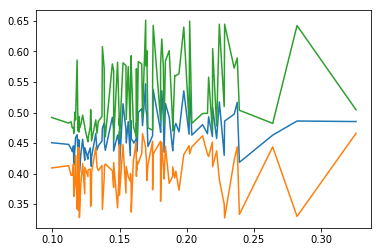

In [109]:
x = group[sort]
y_mean = mean[sort]
y_plus_std = (mean - std)[sort]
y_minus_std = (mean + std)[sort]

plt.plot(x, y_mean)
plt.plot(x, y_plus_std)
plt.plot(x, y_minus_std)